Brandon Szeto (A17002478)

### Import Libraries and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm

### Helper Functions

In [2]:
# Various nonlinearities
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return np.where(x > 0, 1, 0)

# Evaluates g(x) = x_1 * x_2 + x_3
def g(x):
    return x[0] * x[1] + x[2]

# Returns inverse of given matrix
def inv(matrix):
    return np.linalg.inv(matrix)

# L2 Norm Squared
def l2_norm_squared(w):
    return w @ w.T

# Plots iteration versus loss using matplotlib
def plot_loss(loss, title='Iteration Versus Loss'):
    # Plotting index versus value
    plt.plot(loss)

    # Adding labels and title
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)

    # Display the plot
    plt.show()

# Computes N predictions 
def eval_w(w_k, x_train, phi=tanh): # WORKS FINE
    result = []
    for x in x_train:
        x_bias = np.append(x, 1)

        alpha_1 = w_k[0]
        alpha_2 = w_k[5]
        alpha_3 = w_k[10]

        a_1 = [w_k[1], w_k[2], w_k[3], w_k[4]]
        a_2 = [w_k[6], w_k[7], w_k[8], w_k[9]]
        a_3 = [w_k[11], w_k[12], w_k[13], w_k[14]]

        beta = w_k[15]

        result.append(alpha_1 * phi(a_1 @ x_bias) +
                      alpha_2 * phi(a_2 @ x_bias) +
                      alpha_3 * phi(a_3 @ x_bias) +
                      beta)

    return np.array(result)

# Evalutes N residuals
def residual(w_k, x_train, y_train, phi=tanh): # WORKS FINE
    return eval_w(w_k, x_train, phi) - y_train

def test(w_star, x_test, y_test):
    r = residual(w_star, x_test, y_test)
    return l2_norm_squared(r) / len(y_test)

def init_w_rand(seed=42, lower=0, upper=1):
    np.random.seed(seed)
    return np.random.uniform(low=lower, high=upper, size=16)

### Task 1: Computing Gradients

Let $\phi(x): \mathbb{R} \rightarrow \mathbb{R}$ and its derivative $\phi'(x)$ be
$$ \begin{aligned}
    \phi(x) &= \frac{e^x - e^{-x}}{e^x + e^{-x}}                     && = \tanh(x)  \\
   \phi'(x) &= 1 - \Bigl( \frac{e^x - e^{-x}}{e^x + e^{-x}} \Bigr)^2 && = 1 - \tanh^2(x)  \\
   \end{aligned} $$
   \**Later on, when we choose different functions for $\phi$, we will simply redefine $\phi$ and $\phi'$.*

More generally, the expression $f_{\mathbf{w}}(\mathbf{x})$ in (2) can be written as:
$$ f_{\mathbf{w}}(\mathbf{x}) = \sum_{i = 1}^k \alpha_i \phi (a_i^Tx + b_i) + \beta \qquad \forall x \in \mathbb{R}^n $$
where $\phi(x): \mathbb{R} \rightarrow \mathbb{R}$ is an arbitrary activation function. 

The set of parameters $\mathbf{w} \in \mathbb{R}^p$ is defined as
$$\mathbf{w} = \{ (\alpha_1, a_{1n} \cdots a_{1n}, b_1) \cdots (\alpha_k, a_{kn} \cdots a_{kn}, b_k) \beta\}$$
where $p = (n + 1)k + k + 1$. 

The individual parameters $\alpha_i \in \mathbb{R}$, $\beta \in \mathbb{R}$, $a_i \in \mathbb{R}^n$, $b_i \in \mathbb{R}$. In (2), we have $n = k = 3$ and $p = 16$ and
$$\mathbf{w} = \{\alpha_1, a_{11}, a_{12}, a_{13}, b_1, \alpha_2, a_{21}, a_{22}, a_{23}, b_2, \alpha_3, a_{31}, a_{32}, a_{33}, b_3, \beta\}$$

Let the gradient $\nabla_{\mathbf{w}}f_{\mathbf{w}}(\mathbf{x})$ be defined as
$$ \nabla_{\mathbf{w}}f_{\mathbf{w}}(\mathbf{x}) = 
\biggl[
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_1} \quad
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_2} \quad
\cdots
\quad
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_p}
\biggr]^T
$$
where
$$
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_m} =
\begin{cases}
    \phi(a_i^Tx + b_i)            & \text{if } w_m = \alpha_i \text{ for some } i \\
    1                             & \text{if } w_m = \beta \\
    \alpha_i\phi'(a_i^Tx + b_i)x_j & \text{if } w_m = a_{ij} \text{ for some } (i,j) \\
    \alpha_i\phi'(a_i^Tx + b_i)    & \text{if } w_m = b_i \text{ for some } i \\
\end{cases}
$$

In [3]:
'''
w (vector): array of parameters with length p
x (vector): input vector of length 1 x n
k (scalar): layers in the neural network
'''
def gradient(w, x, k=3, phi=tanh, phi_prime=tanh_prime):
    n = len(x) # 3 in this case

    # k rows each with structure [alpha_k a_k1 ... a_1n b_k]
    w_truncated = w[:15]
    W = w_truncated.reshape(k, n + 2) # reshape k x (n + 2) 
    gradient = np.zeros_like(W)

    # for every layer calculate
    for i in range(k):
        alpha_phi_prime = W[i][0] * phi_prime(W[i][1:-1] @ x)
        
        # case of a_i
        gradient[i][0] = phi(W[i][1:-1] @ x)
    
        # case of a_ij
        for j in range(n):
            gradient[i][j + 1] = alpha_phi_prime * x[j]
    
        # case of b_i
        gradient[i][-1] = alpha_phi_prime

    # appending 1 for case of beta
    return np.append(gradient.flatten(), 1) # Shape 1 x p (1 x 16)

### Task 2: Computing Derivative Matrix

The Jacobian matrix of a vector-valued function of several variables is the matrix of all of its first-order partial derivatives. Given the dataset $\{ (x_n, y_n)\}_{n=1}^N$, let $r_n(w) = f_{\mathbf{w}}(x_n) - y_n$ and define $r: \mathbb{R}^p \rightarrow \mathbb{R}^N$ such that:
$$r(w) = \bigl[ r_1(w) \quad r_w(w) \quad \cdots \quad r_N(w) \bigr]^T$$

then the Jacobian matrix $\operatorname{Dr}(\mathbf{w}) \in \mathbb{R}^{n \times p}$ is given by
$$
\operatorname{Dr}(\mathbf{w}) = 
\begin{bmatrix}
\frac{\delta r_1}{\delta w_1} & \frac{\delta r_1}{\delta w_2} & \cdots & \frac{\delta r_1}{\delta w_p} \\
\frac{\delta r_2}{\delta w_1} & \frac{\delta r_2}{\delta w_2} & \cdots & \frac{\delta r_2}{\delta w_p} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\delta r_N}{\delta w_1} & \frac{\delta r_N}{\delta w_2} & \cdots & \frac{\delta r_N}{\delta w_p}
\end{bmatrix} =
\begin{bmatrix}
\frac{\delta f_{\mathbf{w}}(x_1)}{\delta w_1} & \frac{\delta f_{\mathbf{w}}(x_1)}{\delta w_2} & \cdots & \frac{\delta f_{\mathbf{w}}(x_1)}{\delta w_p} \\
\frac{\delta f_{\mathbf{w}}(x_2)}{\delta w_1} & \frac{\delta f_{\mathbf{w}}(x_2)}{\delta w_2} & \cdots & \frac{\delta f_{\mathbf{w}}(x_2)}{\delta w_p} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\delta f_{\mathbf{w}}(x_N)}{\delta w_1} & \frac{\delta f_{\mathbf{w}}(x_N)}{\delta w_2} & \cdots & \frac{\delta f_{\mathbf{w}}(x_N)}{\delta w_p}
\end{bmatrix}
$$

In [4]:
# X: N samples each with 3 points
def jacobian(init_w, x_train, phi=tanh, phi_prime=tanh_prime):
    N = len(x_train)
    jacobian = np.zeros((N, 16))

    for i in range(N):
        jacobian[i, :] = gradient(init_w, x_train[i], 3, phi, phi_prime)

    return jacobian

### Task 3: Levenberg-Marquardt Algorithm

The following is a simple method to generate $N$ random points $\mathbf{x}^{(n)}=\left[x_1^{(n)}, x_2^{(n)}, x_3^{(n)}\right]^T \in \mathbb{R}^3$ such that
$$ \max \left\{\left|x_1^{(n)}\right|,\left|x_2^{(n)}\right|,\left|x_3^{(n)}\right|\right\} \leqslant \Gamma$$
for all $n = 1, 2, \ldots, N$ and their corresponding $\mathbf{y}^{(n)}=x_1^{(n)}x_2^{(n)} + x_3^{(n)}$ values. By default, we have $N = 500$ and $\Gamma = 1$ (convenient for generating the training set).

In [5]:
'''
Parameters:
- N: number of random points
- seed: random seed
- gamma: generate elements in x that are between -gamma and gamma

Return:
- x: shape (500, 3) matrix
- y: shape (500,  ) matrix
'''
def generate_pairs(N=500, seed=42, gamma=1, epsilon=0):
    np.random.seed(seed)
    x = np.random.uniform(-gamma, gamma, size=(N, 3))
    e = np.random.uniform(-epsilon, epsilon, N)
    y = x[:, 0] * x[:, 1] + x[:, 2] + e[:]
    return x, y

def generate_pairs_new(N=500, seed=42, gamma=1, epsilon=0):
    np.random.seed(seed)
    x = np.random.uniform(-gamma, gamma, size=(N, 3))
    e = np.random.uniform(-epsilon, epsilon, N)
    y = x[:, 0] * x[:, 1] + x[:, 1] * x[:, 2] + e[:]
    return x, y

#### Levenberg-Marquardt Algorithm

Initialization. Pick an initial point $w^{(0)}$, an initial trust parameter $\lambda^{(0)}$, $0 < \alpha < 1$, and  $\beta > 1$. 

For $k = 0, 1, \ldots, k^{\text{max}}$:

1) First-order approximation of $r$ at $w^{(k)}$: $\hat{r}(w;w^{(k)}) = r(w^{(k)}) + Dr(w^{(k)})(w - w^{(k)})$.
2) Solve the linear least squares problem: $w^* = \operatorname{arg min} \parallel \hat{r}(w; w^{(k)}) \parallel_2^2 + \lambda^{(k)} \parallel w - w^{(k)} \parallel_2^2$
3) Check and update:
    - If $\parallel r(w^{*})) \parallel_2^2 < \parallel r(w^{(k)})) \parallel_2^2$, set $\lambda^{(k + 1)} = \alpha \lambda^{(k)}$ and $w^{(k + 1)} = w^*$.
    - Otherwise, set $\lambda^{(k)} = \beta \lambda^{(k)}$ and $w^{(k + 1)} = w^{(k)}$

Note that we can rewrite
$$ \begin{aligned}
w^* &= \operatorname{arg min} \left\| \hat{r}(w; w^{(k)}) \right\|_2^2 + \lambda^{(k)} \left\| w - w^{(k)} \right\|_2^2 \\
    &= \operatorname{arg min} \left\| Dr(w^{(k)})w - (Dr(w^{(k)})w^{(k)} - r(w^{(k)})) \right\|_2^2 + \left\| \sqrt{\lambda^{(k)}} w - \sqrt{\lambda^{(k)}} w^{(k)} \right\|_2^2 \\
    &= \operatorname{arg min} \left\| 
    \begin{bmatrix}
    Dr(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} I \\
    \end{bmatrix}w
    -
    \begin{bmatrix}
    Dr(w^{(k)})w^{(k)} - r(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} w^{(k)} \\
    \end{bmatrix}
    \right\|^2_2
\end{aligned} $$
We know the minimizer to be the psuedoinverse. Therefore, we can write:
$$ \begin{aligned}
w^* &= \left(
    \begin{bmatrix}
    Dr(w^{(k)}) \quad
    \sqrt{\lambda^{(k)}} I 
    \end{bmatrix}
    \begin{bmatrix}
    Dr(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} I \\
    \end{bmatrix} 
    \right)^{-1} 
    \begin{bmatrix}
    Dr(w^{(k)}) \quad
    \sqrt{\lambda^{(k)}} I 
    \end{bmatrix} 
    \begin{bmatrix}
    Dr(w^{(k)})w^{(k)} - r(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} w^{(k)} \\
    \end{bmatrix}\\
    &= \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)^{-1} \left( Dr(w^{(k)})^TDr(w^{(k)})w^{(k)} - Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}w^{(k)} \right) \\
    &= \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)^{-1} \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)w^{(k)} - Dr(w^{(k)})^Tr(w^{(k)}) \\
    &= w^{(k)} - \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)^{-1} Dr(w^{(k)})^T r(w^{(k)})
\end{aligned} $$

In [6]:
'''
Levenberg-Marquardt Algorithm:

Parameters:
- train_x: shape (500, 3) matrix 
- train_y: shape (500,  ) matrix
- init_lambda: default 10^-5
- init_w: inital parameters
- alpha: param
- beta: param

Returns:
- w_k: the final p parameters produces by the algorithm
- loss: an array with indices = iteration and value = loss at that iteration
'''
def lm(x, y, w_init, k_max, alpha, beta, init_lambda=10**-5, phi=tanh, phi_prime=tanh_prime):
    w_k = w_init
    l_k = init_lambda
    loss = [0] * k_max
    I = np.eye(16)
    
    for k in tqdm(range(k_max)):
        D = jacobian(w_k, x, phi, phi_prime)
        DT = D.T
        r = residual(w_k, x, y, phi)

        # (16, ) - ( (16, 500) @ (500, 16) )^-1 @ ((16, 500) @ (500, ))
        # (16, ) - (16, 16)^-1 @ (16, )
        # (16, ) - (16, )
        w_star = w_k - inv(DT @ D + l_k * I) @ (DT @ r)

        loss[k] = l2_norm_squared(residual(w_star, x, y, phi)) + l_k * (l2_norm_squared(w_star))

        l2_norm_squared_w_star = l2_norm_squared(w_star)
        l2_norm_squared_w_k = l2_norm_squared(w_k)
        
        # Check and update
        if l2_norm_squared_w_star < l2_norm_squared_w_k:
            # print("----------------------")
            l_k = alpha * l_k
            w_k = w_star
            l2_norm_squared_w_k = l2_norm_squared_w_star
        else:
            l_k = beta * l_k
            # print(f"lambda at {k}: {l_k}")

        # Stopping criterion
        if loss[k] < 0.01:
            break

    return w_k, loss

#### Stopping Criterion

According to the textbook, the algorithm is stopped before the maximum number of iterations $k^{\text{max}}$ if either of the following two conditions hold:
- *Small residual*: $\left\| f(x^{(k + 1)}) \right\|$ is small enough
- *Small optimality condition residual:* $\left\| 2Df(\hat{x})f(\hat{x})\right\|$ is small enough
  
Thus, in the implementation of the algorithm we will stop if the above residuals are less than 0.1 or if we iterate $k^{\text{max}}$ times.

### Task 3ab): Training/Testing loss using $\phi = \operatorname{tanh}(x)$

In [7]:
x_train, y_train = generate_pairs()

#### a) Training with various parameter initializations 

In [8]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=25, alpha=.8, beta=2, init_lambda=10**-5, phi=tanh, phi_prime=tanh_prime)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=25, alpha=.8, beta=2, init_lambda=10**-5, phi=tanh, phi_prime=tanh_prime)

# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=25, alpha=.8, beta=2, init_lambda=10**-5, phi=tanh, phi_prime=tanh_prime)

# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=25, alpha=.8, beta=2, init_lambda=10**-5, phi=tanh, phi_prime=tanh_prime)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

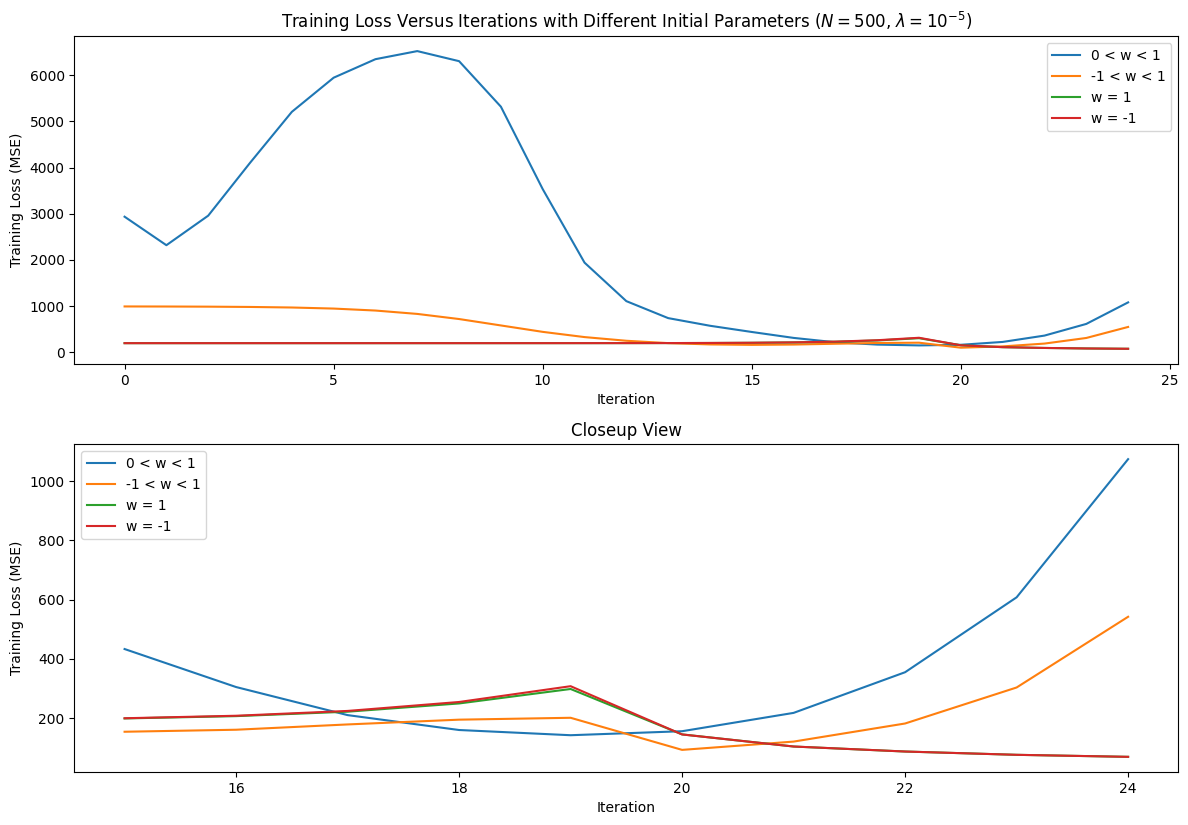

In [9]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{-5}$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(15, 25), loss_1[15:25], label='0 < w < 1')
plt.plot(range(15, 25), loss_2[15:25], label='-1 < w < 1')
plt.plot(range(15, 25), loss_3[15:25], label='w = 1')
plt.plot(range(15, 25), loss_4[15:25], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [10]:
print('Final Training Losses (MSE) at N = 500:')
print('---------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_train, y_train)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_train, y_train)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_train, y_train)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_train, y_train)}')

Final Training Losses (MSE) at N = 500:
---------------------------------------
MSE ( 0 < w < 1) : 0.49979467307470016
MSE (-1 < w < 1) : 0.3288456501998761
MSE (w =  1)     : 0.11862688613680664
MSE (w = -1)     : 0.11862988532790827


#### b) Testing on $N_T = 100$ testing points with various $\lambda$, $\Gamma_T$

In [11]:
x_test_g1, y_test_g1 = generate_pairs(N=100, seed=6, gamma=1, epsilon=0)
x_test_g2, y_test_g2 = generate_pairs(N=100, seed=6, gamma=0.5, epsilon=0)
x_test_g3, y_test_g3 = generate_pairs(N=100, seed=6, gamma=1.5, epsilon=0)

##### i) $\lambda = 10^{-5}, \Gamma = 0.5, 1, 1.5$

In [12]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.5353855164854787
MSE (-1 < w < 1) : 0.3711968720740824
MSE (w =  1)     : 0.13233396260873004
MSE (w = -1)     : 0.13233893427227492
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.2052140861509576
MSE (-1 < w < 1) : 0.19893863540545964
MSE (w =  1)     : 0.009531220512013829
MSE (w = -1)     : 0.009534260070900743
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.4298439131415386
MSE (-1 < w < 1) : 1.0422841392816087
MSE (w =  1)     : 0.7099421983242273
MSE (w = -1)     : 0.7099827049929704


##### ii) $\lambda = 1, \Gamma = 0.5, 1, 1.5$

In [13]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=25, alpha=.8, beta=2, init_lambda=1, phi=tanh, phi_prime=tanh_prime)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=25, alpha=.8, beta=2, init_lambda=1, phi=tanh, phi_prime=tanh_prime)

# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=25, alpha=.8, beta=2, init_lambda=1, phi=tanh, phi_prime=tanh_prime)

# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=25, alpha=.8, beta=2, init_lambda=1, phi=tanh, phi_prime=tanh_prime)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [14]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 1$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(0, 6), loss_1[0:6], label='0 < w < 1')
plt.plot(range(0, 6), loss_2[0:6], label='-1 < w < 1')
plt.plot(range(0, 6), loss_3[0:6], label='w = 1')
plt.plot(range(0, 6), loss_4[0:6], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [15]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=1:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=1:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=1:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=1:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.43213904889420846
MSE (-1 < w < 1) : 0.25730272565311263
MSE (w =  1)     : 0.1295477823673979
MSE (w = -1)     : 0.1295477939570153
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=1:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.11477700737943726
MSE (-1 < w < 1) : 0.09559178002711441
MSE (w =  1)     : 0.007897035908121262
MSE (w = -1)     : 0.00789703864403702
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=1:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.321330951420337
MSE (-1 < w < 1) : 0.91183369642318
MSE (w =  1)     : 0.6744327583019957
MSE (w = -1)     : 0.6744327770662824


##### iii) $\lambda = 10^{5}, \Gamma = 0.5, 1, 1.5$

In [16]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=tanh, phi_prime=tanh_prime)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=tanh, phi_prime=tanh_prime)

# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=tanh, phi_prime=tanh_prime)

# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=tanh, phi_prime=tanh_prime)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

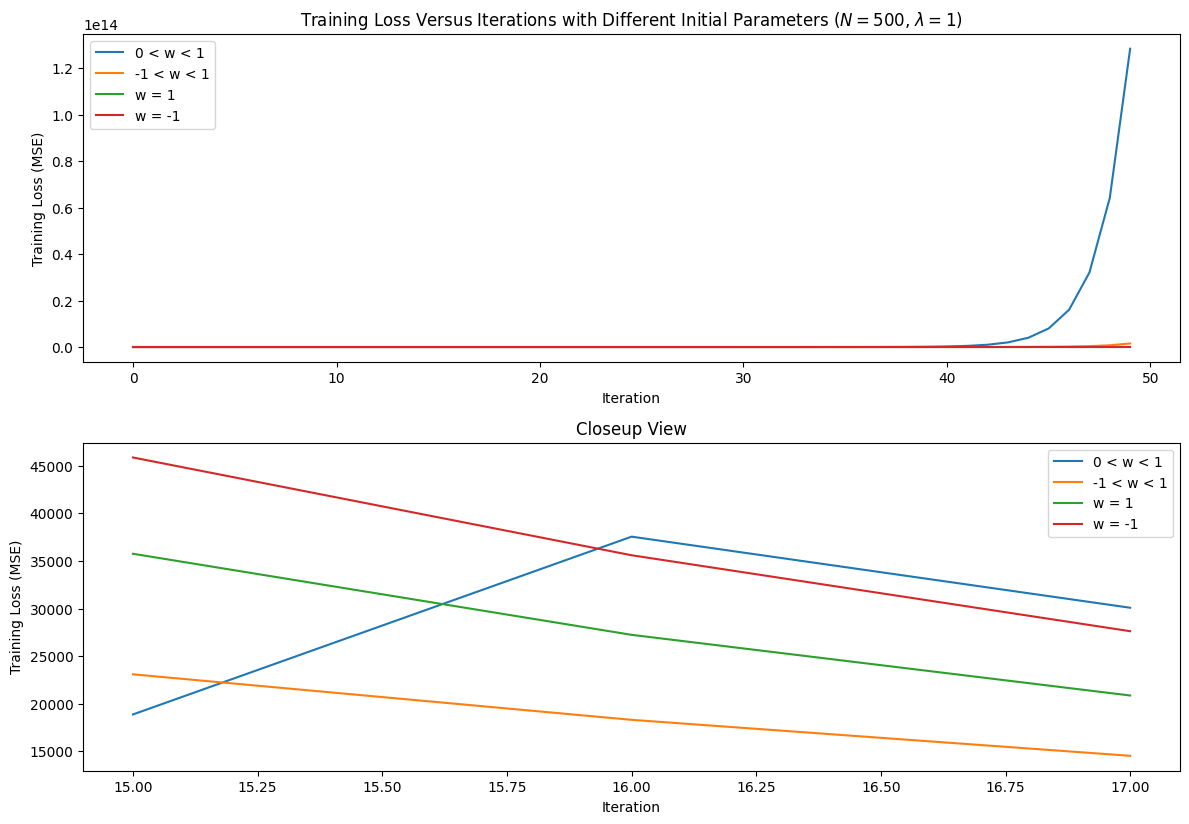

In [17]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 1$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(15, 18), loss_1[15:18], label='0 < w < 1')
plt.plot(range(15, 18), loss_2[15:18], label='-1 < w < 1')
plt.plot(range(15, 18), loss_3[15:18], label='w = 1')
plt.plot(range(15, 18), loss_4[15:18], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [18]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.44425116635931855
MSE (-1 < w < 1) : 0.36922986188560225
MSE (w =  1)     : 0.12960430635941983
MSE (w = -1)     : 0.12963055741722562
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.119270535479836
MSE (-1 < w < 1) : 0.04758106550993269
MSE (w =  1)     : 0.008141902881831893
MSE (w = -1)     : 0.008158873074669061
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.3412372540227597
MSE (-1 < w < 1) : 1.3172603055297711
MSE (w =  1)     : 0.6822187846464844
MSE (w = -1)     : 0.6827086016157645


#### Comments
The loss that is plotted in each iteration versus training loss plot is defined as:
$$ l(\mathbf{w}) = \sum_{n = 1}^N r_n^2(\mathbf{w}) + \lambda \left\| \mathbf{w} \right\|^2_2$$

The error that is calculated for the training and testing data is mean squared error:
$$ \frac{1}{N} \sum_{i = 1}^N (\hat{y}_i - y_i)^2 $$

**Various Parameter Initializations**:
- When initializing $\mathbf{w}$ randomly such that $0 < \mathbf{w} < 1$, the loss struggles to converge to a local minimum, then proceeds to later diverge.
- When initializing $\mathbf{w}$ randomly such that $-1 < \mathbf{w} < 1$, the loss doesn't start off as high as $0 < \mathbf{w} < 1$, but also proceeds to later diverge.
- When initializing $\mathbf{w}$ to all $1$, the loss seems to converge to a value less than 200.
- When initializing $\mathbf{w}$ to all $-1$, the loss seems to converge to a value less than 200.

**Various choices of $\lambda$**:
- When $\lambda = 10^{-5}$, the above behavior for all intializations occurs at around 20 iterations.
- When $\lambda = 1$, the above behavior for all intializations occurs at around 5 iterations.
- When $\lambda = 10^{5}$, the above behvaior for all initializations occurs at around 15 iterations.
Varying $\lambda$ changes how much we want the $\left\| \mathbf{w} \right\|^2_2$ term to have an impact on our loss function. As a result, when $\lambda$ is small, our iterations are dominated by $\sum_{n = 1}^N r_n^2(\mathbf{w})$ (until $\lambda$ gets big enough as iterations pass). When $\lambda$ is large, our iterations are dominated by $\left\| \mathbf{w} \right\|^2_2$, resulting in little to no impact of $\sum_{n = 1}^N r_n^2(\mathbf{w})$ on the iterations of the algorithm. 
  
**Various choices of $\Gamma_T$**:
- When varying $\Gamma_T$, MSE is consistently lower when $\Gamma_T$ is smaller, and MSE is consistently higher when $\Gamma_T$ is larger in both the test and train set.


### Task 3c): Training/Testing loss with different w, $\lambda$, $\Gamma$ using $g(x) = x_1x_2 + x_2x_3$

In [19]:
x_train, y_train = generate_pairs_new()

#### a) Training with various parameter initializations 

In [20]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=25, alpha=.8, beta=2, init_lambda=10**-5)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=25, alpha=.8, beta=2, init_lambda=10**-5)

# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=25, alpha=.8, beta=2, init_lambda=10**-5)

# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=25, alpha=.8, beta=2, init_lambda=10**-5)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

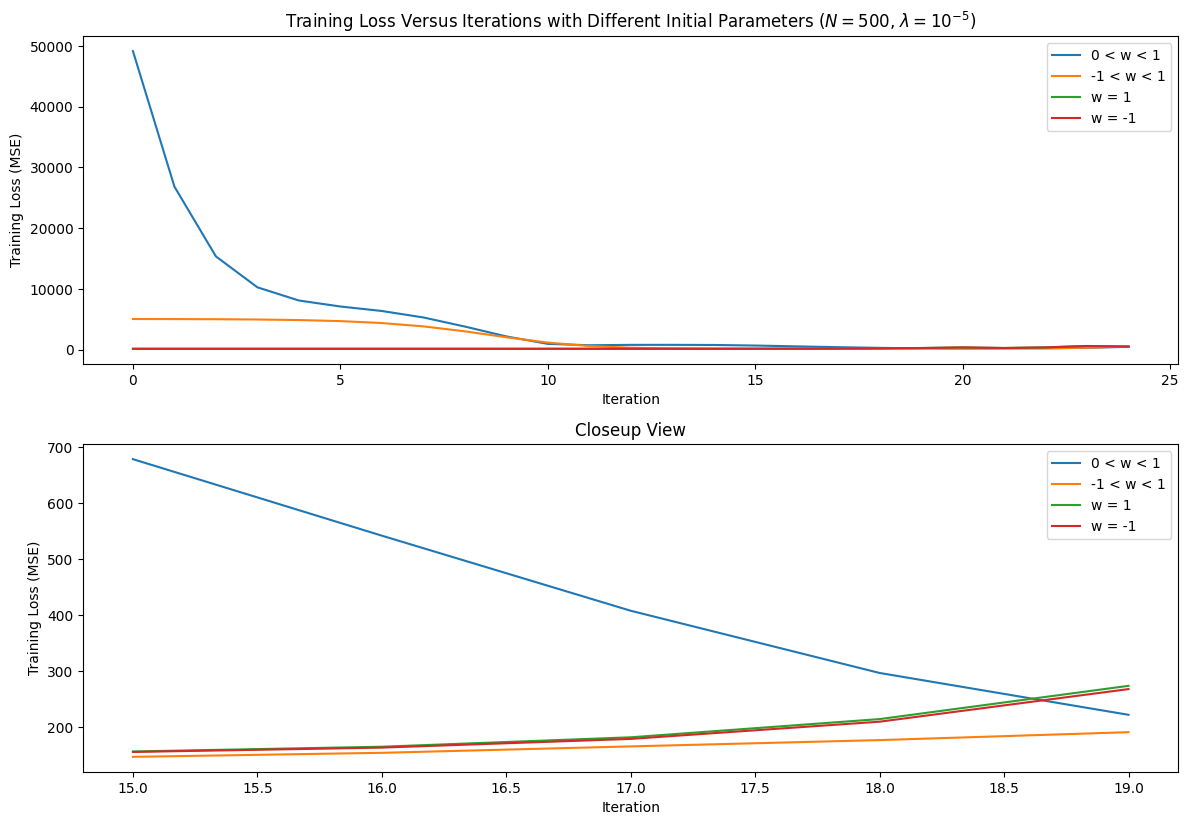

In [21]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{-5}$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(15, 20), loss_1[15:20], label='0 < w < 1')
plt.plot(range(15, 20), loss_2[15:20], label='-1 < w < 1')
plt.plot(range(15, 20), loss_3[15:20], label='w = 1')
plt.plot(range(15, 20), loss_4[15:20], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [22]:
print('Final Training Losses (MSE) at N = 500:')
print('---------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_train, y_train)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_train, y_train)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_train, y_train)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_train, y_train)}')

Final Training Losses (MSE) at N = 500:
---------------------------------------
MSE ( 0 < w < 1) : 0.25457940697263376
MSE (-1 < w < 1) : 0.25931834889853267
MSE (w =  1)     : 0.2670665870881326
MSE (w = -1)     : 0.2642718325678243


#### b) Testing on $N_T = 100$ testing points with various $\lambda$, $\Gamma_T$

In [23]:
x_test_g1, y_test_g1 = generate_pairs_new(N=100, seed=6, gamma=1, epsilon=0)
x_test_g2, y_test_g2 = generate_pairs_new(N=100, seed=6, gamma=0.5, epsilon=0)
x_test_g3, y_test_g3 = generate_pairs_new(N=100, seed=6, gamma=1.5, epsilon=0)

##### i) $\lambda = 10^{-5}, \Gamma = 0.5, 1, 1.5$

In [24]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.21094428235983093
MSE (-1 < w < 1) : 0.21547916556923813
MSE (w =  1)     : 0.22394837216688893
MSE (w = -1)     : 0.22132626962455487
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.014257378695446708
MSE (-1 < w < 1) : 0.016235820858079883
MSE (w =  1)     : 0.018237945162306812
MSE (w = -1)     : 0.01526510056401202
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.090661446142522
MSE (-1 < w < 1) : 1.0993935082933022
MSE (w =  1)     : 1.1210317144549133
MSE (w = -1)     : 1.1190104525715896


##### ii) $\lambda = 1, \Gamma = 0.5, 1, 1.5$

In [25]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=1, phi=relu, phi_prime=relu_prime)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=1, phi=relu, phi_prime=relu_prime)

# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=1, phi=relu, phi_prime=relu_prime)

# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=1, phi=relu, phi_prime=relu_prime)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 1$)')
plt.legend()

# Plot 2: Close-up View
plt.subplot(3, 1, 2)
plt.plot(range(4, 12), loss_1[4:12], label='0 < w < 1')
plt.plot(range(4, 12), loss_2[4:12], label='-1 < w < 1')
plt.plot(range(4, 12), loss_3[4:12], label='w = 1')
plt.plot(range(4, 12), loss_4[4:12], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [27]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.2729514326125101
MSE (-1 < w < 1) : 0.4229756590210068
MSE (w =  1)     : 0.39861531503208314
MSE (w = -1)     : 0.2487051382725734
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.049459608241341366
MSE (-1 < w < 1) : 0.19296495023762048
MSE (w =  1)     : 0.19790544814944572
MSE (w = -1)     : 0.024961899543878237
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.1691801315873012
MSE (-1 < w < 1) : 1.3266960026052614
MSE (w =  1)     : 1.21994632588494
MSE (w = -1)     : 1.1710256141950082


##### iii) $\lambda = 10^{5}, \Gamma = 0.5, 1, 1.5$

In [28]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=relu, phi_prime=relu_prime)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=relu, phi_prime=relu_prime)

# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=relu, phi_prime=relu_prime)

# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=10**5, phi=relu, phi_prime=relu_prime)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{5}$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(15, 30), loss_1[15:30], label='0 < w < 1')
plt.plot(range(15, 30), loss_2[15:30], label='-1 < w < 1')
plt.plot(range(15, 30), loss_3[15:30], label='w = 1')
plt.plot(range(15, 30), loss_4[15:30], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [30]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.24613386605596502
MSE (-1 < w < 1) : 0.4154675443517444
MSE (w =  1)     : 0.28438336808949893
MSE (w = -1)     : 0.23778942074462364
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.024837082791853652
MSE (-1 < w < 1) : 0.2349243311302586
MSE (w =  1)     : 0.05494967350566394
MSE (w = -1)     : 0.035638579561525933
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.1551506992242928
MSE (-1 < w < 1) : 1.2950180471644208
MSE (w =  1)     : 1.1762636713276635
MSE (w = -1)     : 1.1269102395020985


#### Comments
The loss that is plotted in each iteration versus training loss plot is defined as:
$$ l(\mathbf{w}) = \sum_{n = 1}^N r_n^2(\mathbf{w}) + \lambda \left\| \mathbf{w} \right\|^2_2$$

The error that is calculated for the training and testing data is mean squared error:
$$ \frac{1}{N} \sum_{i = 1}^N (\hat{y}_i - y_i)^2 $$

**Various Parameter Initializations**:
- When initializing $\mathbf{w}$ randomly such that $0 < \mathbf{w} < 1$, the loss converges.
- When initializing $\mathbf{w}$ randomly such that $-1 < \mathbf{w} < 1$, the loss doesn't start off as high as $0 < \mathbf{w} < 1$, but proceeds to converge.
- When initializing $\mathbf{w}$ to all $1$, the loss seems to converge.
- When initializing $\mathbf{w}$ to all $-1$, the loss seems to converge.

**Various choices of $\lambda$**:
- When $\lambda = 10^{-5}$, the above behavior for all intializations occurs at around 17 iterations.
- When $\lambda = 1$, all the intializations seem to diverge.
- When $\lambda = 10^{5}$, the above behvaior for all initializations occurs at around 20 iterations.
Varying $\lambda$ changes how much we want the $\left\| \mathbf{w} \right\|^2_2$ term to have an impact on our loss function. As a result, when $\lambda$ is small, our iterations are dominated by $\sum_{n = 1}^N r_n^2(\mathbf{w})$ (until $\lambda$ gets big enough as iterations pass). When $\lambda$ is large, our iterations are dominated by $\left\| \mathbf{w} \right\|^2_2$, resulting in little to no impact of $\sum_{n = 1}^N r_n^2(\mathbf{w})$ on the iterations of the algorithm. 
  
**Various choices of $\Gamma_T$**:
- When varying $\Gamma_T$, MSE is consistently lower when $\Gamma_T$ is smaller, and MSE is consistently higher when $\Gamma_T$ is larger in both the test and train set.

**Difference with previous $g$**
- I will initialize the values of the training and testing datasets to the new function $g$. We can reuse the algorithm framework to rerun iterations of the function $g$.
- This new nonlinear function seems to be easier to find a $\mathbf{w}$ for. It seems that for all the same cases as with $g = x_1x_2 + x_3$, we see similar converging/diverging at a slightly faster rate. The intuition here is that since there is an additional term being multiplied, changes in the terms are more noticeable and thus more likely to be noticed within an iteration.

### Task 3d): Training/Testing loss with different w, $\lambda$, $\Gamma$ with added noise

In [31]:
x_train_e1, y_train_e1 = generate_pairs(N=500, seed=41, gamma=1, epsilon=10**-5)
x_train_e2, y_train_e2 = generate_pairs(N=500, seed=41, gamma=1, epsilon=1)

#### ai) Training with various parameter initializations $\epsilon = 10^{-5}$

In [32]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_e1, loss_1 = lm(x=x_train_e1, y=y_train_e1, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=10**-5)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_e2, loss_2 = lm(x=x_train_e1, y=y_train_e1, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=10**-5)

# All ones
w_3 = np.ones(16)
w_star_e3, loss_3 = lm(x=x_train_e1, y=y_train_e1, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=10**-5)

# All negative ones
w_4 = -np.ones(16)
w_star_e4, loss_4 = lm(x=x_train_e1, y=y_train_e1, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=10**-5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{-5}$, $\epsilon = 10^{-5}$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(14, 18), loss_1[14:18], label='0 < w < 1')
plt.plot(range(14, 18), loss_2[14:18], label='-1 < w < 1')
plt.plot(range(14, 18), loss_3[14:18], label='w = 1')
plt.plot(range(14, 18), loss_4[14:18], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [34]:
print('Final Training Losses (MSE) at N = 500:')
print('---------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_train, y_train)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_train, y_train)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_train, y_train)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_train, y_train)}')

Final Training Losses (MSE) at N = 500:
---------------------------------------
MSE ( 0 < w < 1) : 0.3698403149284369
MSE (-1 < w < 1) : 0.5883611043466517
MSE (w =  1)     : 0.6434516234998018
MSE (w = -1)     : 0.6434516264723263


#### aii) Training with various parameter initializations $\epsilon = 1$

In [35]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_ee1, loss_1 = lm(x=x_train_e2, y=y_train_e2, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=10**-5, phi=relu, phi_prime=relu_prime)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_ee2, loss_2 = lm(x=x_train_e2, y=y_train_e2, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=10**-5, phi=relu, phi_prime=relu_prime)

# All ones
w_3 = np.ones(16)
w_star_ee3, loss_3 = lm(x=x_train_e2, y=y_train_e2, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=10**-5, phi=relu, phi_prime=relu_prime)

# All negative ones
w_4 = -np.ones(16)
w_star_ee4, loss_4 = lm(x=x_train_e2, y=y_train_e2, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=10**-5, phi=relu, phi_prime=relu_prime)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{-5}$, $\epsilon = 1$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(15, 17), loss_1[15:17], label='0 < w < 1')
plt.plot(range(15, 17), loss_2[15:17], label='-1 < w < 1')
plt.plot(range(15, 17), loss_3[15:17], label='w = 1')
plt.plot(range(15, 17), loss_4[15:17], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [37]:
print('Final Training Losses (MSE) at N = 500:')
print('---------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_1, x_train, y_train)}')
print(f'MSE (-1 < w < 1) : {test(w_star_2, x_train, y_train)}')
print(f'MSE (w =  1)     : {test(w_star_3, x_train, y_train)}')
print(f'MSE (w = -1)     : {test(w_star_4, x_train, y_train)}')

Final Training Losses (MSE) at N = 500:
---------------------------------------
MSE ( 0 < w < 1) : 0.30719591827006376
MSE (-1 < w < 1) : 0.5284791883711544
MSE (w =  1)     : 0.34540563195422075
MSE (w = -1)     : 0.2706014921020789


#### b) Testing on $N_T = 100$ testing points with various $\lambda$, $\Gamma_T$

In [38]:
x_test_g1, y_test_g1 = generate_pairs(N=100, seed=6, gamma=1, epsilon=0)
x_test_g2, y_test_g2 = generate_pairs(N=100, seed=6, gamma=0.5, epsilon=0)
x_test_g3, y_test_g3 = generate_pairs(N=100, seed=6, gamma=1.5, epsilon=0)

##### i) $\lambda = 10^{-5}, \Gamma = 0.5, 1, 1.5$, $\epsilon = 10^{-5}$

In [39]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon=10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon=10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.404939091150653
MSE (-1 < w < 1) : 0.2837975298951801
MSE (w =  1)     : 0.1364163046642394
MSE (w = -1)     : 0.1364163046189511
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.09424304399478531
MSE (-1 < w < 1) : 0.11454332401926337
MSE (w =  1)     : 0.010270911087905964
MSE (w = -1)     : 0.010270911100743081
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.2894465129344166
MSE (-1 < w < 1) : 0.936429252015781
MSE (w =  1)     : 0.6980808195010979
MSE (w = -1)     : 0.6980808188514807


##### ii) $\lambda = 1, \Gamma = 0.5, 1, 1.5$, $\epsilon = 10^{-5}$

In [40]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_e1, loss_1 = lm(x=x_train_e1, y=y_train_e1, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=1)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_e2, loss_2 = lm(x=x_train_e1, y=y_train_e1, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=1)

# All ones
w_3 = np.ones(16)
w_star_e3, loss_3 = lm(x=x_train_e1, y=y_train_e1, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=1)

# All negative ones
w_4 = -np.ones(16)
w_star_e4, loss_4 = lm(x=x_train_e1, y=y_train_e1, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=1)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

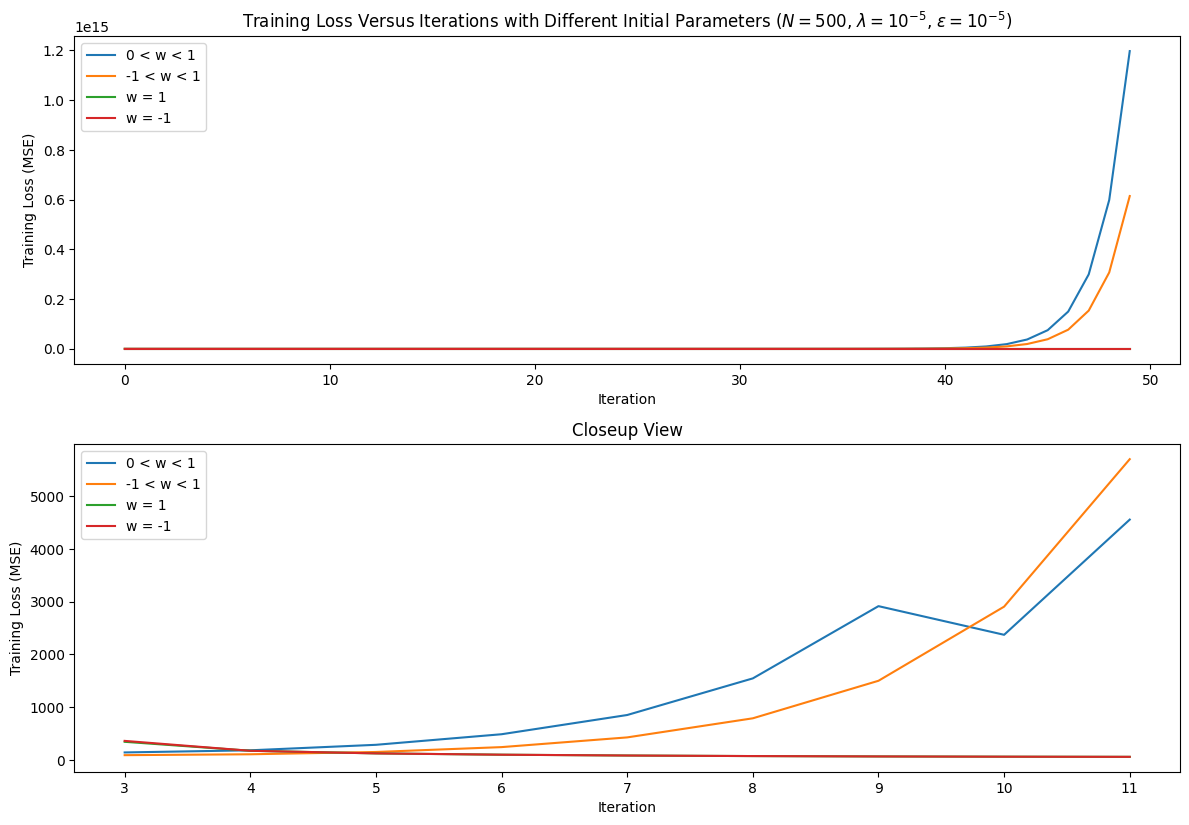

In [41]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{-5}$, $\epsilon = 10^{-5}$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(3, 12), loss_1[3:12], label='0 < w < 1')
plt.plot(range(3, 12), loss_2[3:12], label='-1 < w < 1')
plt.plot(range(3, 12), loss_3[3:12], label='w = 1')
plt.plot(range(3, 12), loss_4[3:12], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [42]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon=10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon=10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon=10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.4288231842629853
MSE (-1 < w < 1) : 0.3181984432613449
MSE (w =  1)     : 0.13641630617001005
MSE (w = -1)     : 0.13641630607531638
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.10925025887351522
MSE (-1 < w < 1) : 0.1370116016133465
MSE (w =  1)     : 0.010270911180393494
MSE (w = -1)     : 0.010270911473494695
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon=10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.3213929000230595
MSE (-1 < w < 1) : 0.9891222614258467
MSE (w =  1)     : 0.6980808277430252
MSE (w = -1)     : 0.6980808239242993


##### iii) $\lambda = 10^{5}, \Gamma = 0.5, 1, 1.5$, $\epsilon = 10^{-5}$

In [43]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_e1, loss_1 = lm(x=x_train_e1, y=y_train_e1, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_e2, loss_2 = lm(x=x_train_e1, y=y_train_e1, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

# All ones
w_3 = np.ones(16)
w_star_e3, loss_3 = lm(x=x_train_e1, y=y_train_e1, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

# All negative ones
w_4 = -np.ones(16)
w_star_e4, loss_4 = lm(x=x_train_e1, y=y_train_e1, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

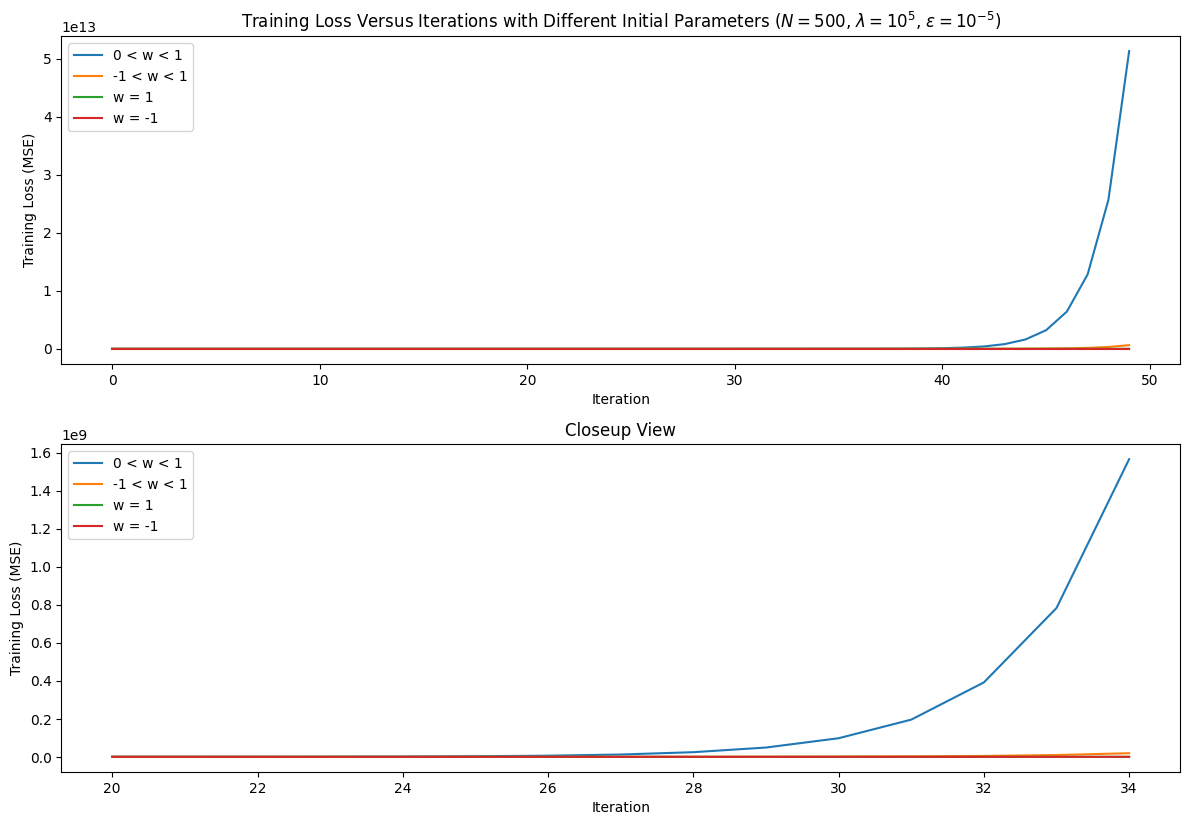

In [44]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{5}$, $\epsilon = 10^{-5}$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(20, 35), loss_1[20:35], label='0 < w < 1')
plt.plot(range(20, 35), loss_2[20:35], label='-1 < w < 1')
plt.plot(range(20, 35), loss_3[20:35], label='w = 1')
plt.plot(range(20, 35), loss_4[20:35], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [45]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon-10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon-10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon-10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon-10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.4400970345959643
MSE (-1 < w < 1) : 0.35669508705996966
MSE (w =  1)     : 0.29398949850435097
MSE (w = -1)     : 0.13719385951763757
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon-10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.11354725159795652
MSE (-1 < w < 1) : 0.0461538662903567
MSE (w =  1)     : 0.054894790486716055
MSE (w = -1)     : 0.010913007279815456
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon-10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.339662147830358
MSE (-1 < w < 1) : 1.2771212565956893
MSE (w =  1)     : 1.0531267222421008
MSE (w = -1)     : 0.7061549918822472


##### iv) $\lambda = 10^{-5}, \Gamma = 0.5, 1, 1.5$, $\epsilon = 1$

In [46]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon=1:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_ee1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_ee2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_ee3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_ee4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon=1:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_ee1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_ee2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_ee3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_ee4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon=1:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_ee1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_ee2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_ee3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_ee4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**-5, epsilon=1:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.4174081001480384
MSE (-1 < w < 1) : 0.23221691694343669
MSE (w =  1)     : 0.4224542934317362
MSE (w = -1)     : 0.22998532080256548
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**-5, epsilon=1:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.08057021127873969
MSE (-1 < w < 1) : 0.0559212251987754
MSE (w =  1)     : 0.12907797246344657
MSE (w = -1)     : 0.09430132341552167
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**-5, epsilon=1:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.3390539071858671
MSE (-1 < w < 1) : 0.9237760662024705
MSE (w =  1)     : 1.2603582596825484
MSE (w = -1)     : 0.819037347710865


##### v) $\lambda = 1, \Gamma = 0.5, 1, 1.5$, $\epsilon = 1$

In [47]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_e1, loss_1 = lm(x=x_train_e2, y=y_train_e2, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=1)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_e2, loss_2 = lm(x=x_train_e2, y=y_train_e2, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=1)

# All ones
w_3 = np.ones(16)
w_star_e3, loss_3 = lm(x=x_train_e2, y=y_train_e2, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=1)

# All negative ones
w_4 = -np.ones(16)
w_star_e4, loss_4 = lm(x=x_train_e2, y=y_train_e2, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=1)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

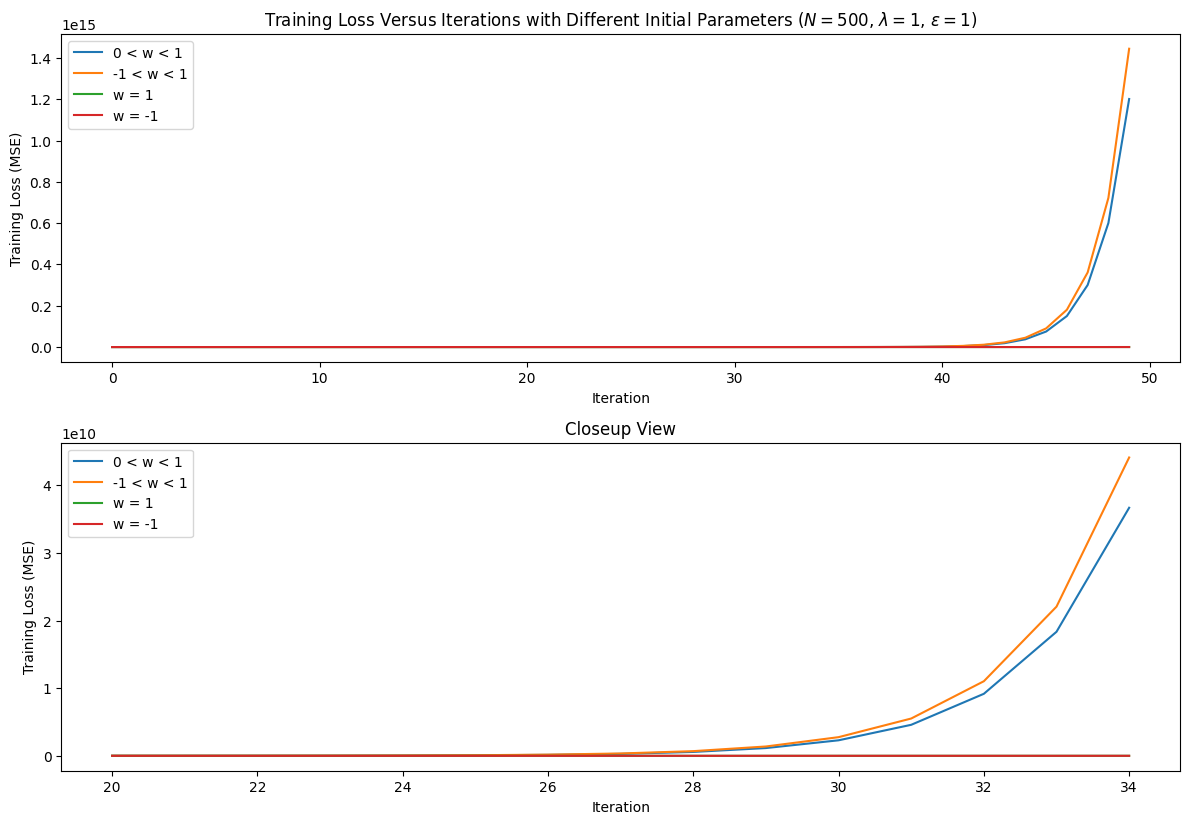

In [48]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 1$, $\epsilon = 1$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(20, 35), loss_1[20:35], label='0 < w < 1')
plt.plot(range(20, 35), loss_2[20:35], label='-1 < w < 1')
plt.plot(range(20, 35), loss_3[20:35], label='w = 1')
plt.plot(range(20, 35), loss_4[20:35], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [49]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=1, epsilon-10**-5:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=1, epsilon-10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=1, epsilon-10**-5:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=1, epsilon-10**-5:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.4377399758734096
MSE (-1 < w < 1) : 0.3619437776901625
MSE (w =  1)     : 0.13043022287387332
MSE (w = -1)     : 0.13042977609630915
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=1, epsilon-10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.11675658324627251
MSE (-1 < w < 1) : 0.1893977407647885
MSE (w =  1)     : 0.008044650397386588
MSE (w = -1)     : 0.00804463899723531
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=1, epsilon-10**-5:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.3294339215301516
MSE (-1 < w < 1) : 1.030268096832706
MSE (w =  1)     : 0.6773739876276779
MSE (w = -1)     : 0.6773753180496418


##### vi) $\lambda = 10^{5}, \Gamma = 0.5, 1, 1.5$, $\epsilon = 1$

In [50]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_e1, loss_1 = lm(x=x_train_e2, y=y_train_e2, w_init=w_1, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_e2, loss_2 = lm(x=x_train_e2, y=y_train_e2, w_init=w_2, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

# All ones
w_3 = np.ones(16)
w_star_e3, loss_3 = lm(x=x_train_e2, y=y_train_e2, w_init=w_3, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

# All negative ones
w_4 = -np.ones(16)
w_star_e4, loss_4 = lm(x=x_train_e2, y=y_train_e2, w_init=w_4, k_max=50, alpha=.8, beta=2, init_lambda=10**5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

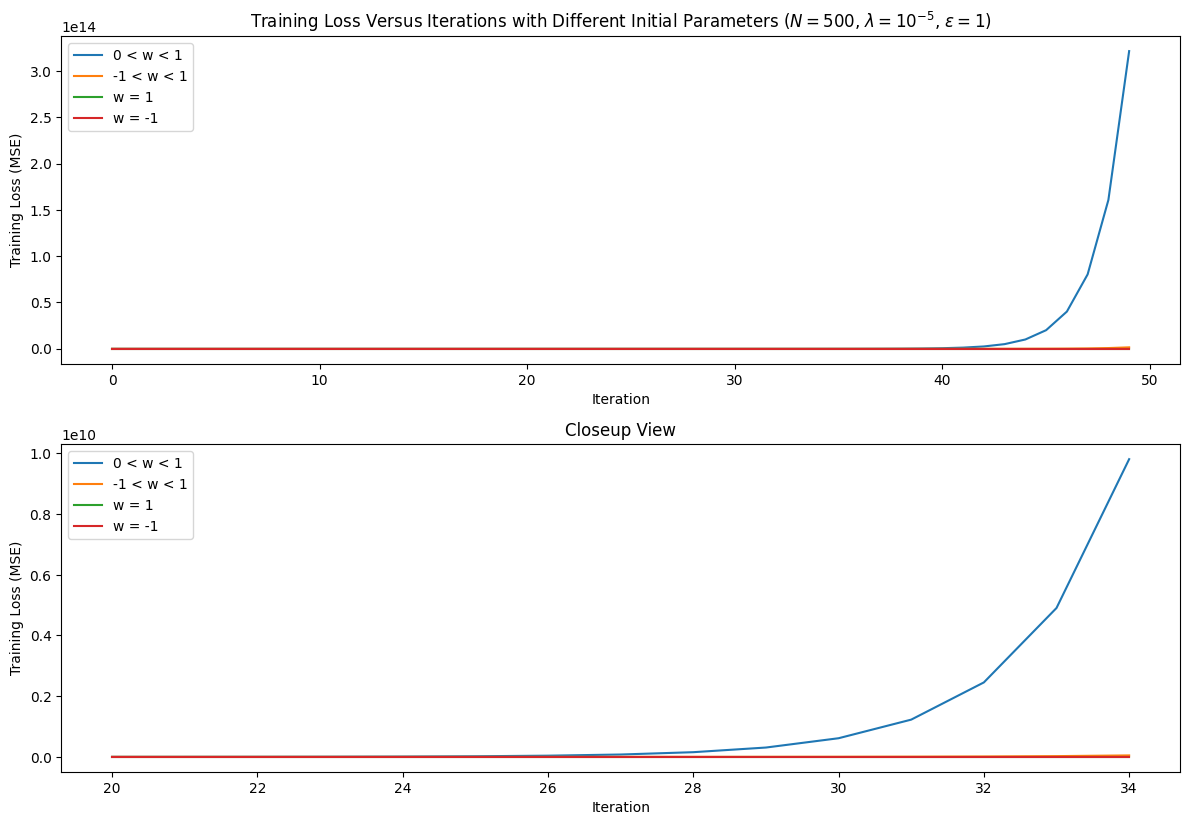

In [51]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Versus Iterations with Different Initial Parameters ($N = 500$, $\lambda = 10^{-5}$, $\epsilon = 1$)')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(20, 35), loss_1[20:35], label='0 < w < 1')
plt.plot(range(20, 35), loss_2[20:35], label='-1 < w < 1')
plt.plot(range(20, 35), loss_3[20:35], label='w = 1')
plt.plot(range(20, 35), loss_4[20:35], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [52]:
print('Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**5, epsilon=1:')
print('------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g1, y_test_g1)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g1, y_test_g1)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g1, y_test_g1)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g1, y_test_g1)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**5, epsilon=1:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g2, y_test_g2)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g2, y_test_g2)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g2, y_test_g2)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g2, y_test_g2)}')

print('Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**5, epsilon=1:')
print('--------------------------------------------------------------------')
print(f'MSE ( 0 < w < 1) : {test(w_star_e1, x_test_g3, y_test_g3)}')
print(f'MSE (-1 < w < 1) : {test(w_star_e2, x_test_g3, y_test_g3)}')
print(f'MSE (w =  1)     : {test(w_star_e3, x_test_g3, y_test_g3)}')
print(f'MSE (w = -1)     : {test(w_star_e4, x_test_g3, y_test_g3)}')

Final Testing Losses (MSE) with N_T = 100, gamma=1, lambda=10**5, epsilon=1:
------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.45575256628446575
MSE (-1 < w < 1) : 0.3840998693397328
MSE (w =  1)     : 0.13173758771674254
MSE (w = -1)     : 0.1317401127735275
Final Testing Losses (MSE) with N_T = 100, gamma=0.5, lambda=10**5, epsilon=1:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 0.12671260450274546
MSE (-1 < w < 1) : 0.05068859151700586
MSE (w =  1)     : 0.008254510342513604
MSE (w = -1)     : 0.008259322065441908
Final Testing Losses (MSE) with N_T = 100, gamma=1.5, lambda=10**5, epsilon=1:
--------------------------------------------------------------------
MSE ( 0 < w < 1) : 1.3552466877860834
MSE (-1 < w < 1) : 1.3482499486761008
MSE (w =  1)     : 0.6828906186764491
MSE (w = -1)     : 0.6831820886745952


#### Comments
The loss that is plotted in each iteration versus training loss plot is defined as:
$$ l(\mathbf{w}) = \sum_{n = 1}^N r_n^2(\mathbf{w}) + \lambda \left\| \mathbf{w} \right\|^2_2$$

The error that is calculated for the training and testing data is mean squared error:
$$ \frac{1}{N} \sum_{i = 1}^N (\hat{y}_i - y_i)^2 $$

**Various Parameter Initializations**:
- When initializing $\mathbf{w}$ randomly such that $0 < \mathbf{w} < 1$, the loss struggles to converge to a local minimum, then proceeds to later diverge.
- When initializing $\mathbf{w}$ randomly such that $-1 < \mathbf{w} < 1$, the loss doesn't start off as high as $0 < \mathbf{w} < 1$, but also proceeds to later diverge.
- When initializing $\mathbf{w}$ to all $1$, the loss seems to converge.
- When initializing $\mathbf{w}$ to all $-1$, the loss seems to converge.

**Various choices of $\lambda$**:
- When $\lambda = 10^{-5}$, the above behavior for all intializations occurs at around 17 iterations.
- When $\lambda = 1$, all the intializations seem to diverge.
- When $\lambda = 10^{5}$, the above behvaior for all initializations occurs at around 20 iterations.
Varying $\lambda$ changes how much we want the $\left\| \mathbf{w} \right\|^2_2$ term to have an impact on our loss function. As a result, when $\lambda$ is small, our iterations are dominated by $\sum_{n = 1}^N r_n^2(\mathbf{w})$ (until $\lambda$ gets big enough as iterations pass). When $\lambda$ is large, our iterations are dominated by $\left\| \mathbf{w} \right\|^2_2$, resulting in little to no impact of $\sum_{n = 1}^N r_n^2(\mathbf{w})$ on the iterations of the algorithm. 
  
**Various choices of $\Gamma_T$**:
- When varying $\Gamma_T$, MSE is consistently lower when $\Gamma_T$ is smaller, and MSE is consistently higher when $\Gamma_T$ is larger in both the test and train set.

**Noisy versus Unnoisy**
- When the training dataset is very noisy (i.e. $\epsilon = 1$ in the above tests), we see all the initializations and settings for $\Gamma_T$ and $\lambda$ have more diverging cases. This is likely a result of being unable to recognize the pattern amongst all the noise, leading to the measured loss at each iteration increasing. However, when the training dataset is slightly noisy (i.e. $\epsilon = 10^{-5}$ in the above tests) we see slower convergence on the training iteration loss, but see better generalization when measuring mean squared error on our testing dataset. This is likely because deliberately adding noise to the training dataset will help prevent the model from overfitting the training dataset.